# Convolutional Neural Network for Text Classification

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics


import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
print(tf.__version__)

%matplotlib inline

import sys
sys.path.append("../..")

from E4525_ML.notebook_utils import get_logger,LoggingCallback
from E4525_ML import text
from E4525_ML import plots

1.13.1


In [2]:
#
from tensorflow.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
logger=get_logger("CNN_Binary_Text_AmazonReviews.log")

In [4]:
seed=456
np.random.seed(seed)

### Data

In [5]:
reviews_filename="../../raw/amazon-reviews/Reviews.csv"

In [6]:
data=pd.read_csv(reviews_filename)

In [7]:
data_dir=r"../../data/amazon-reviews"

### Split into Train, Validation and Test Sets

In [8]:
documents_all=data["Text"].as_matrix()
labels_all=data["Score"].as_matrix()
print(documents_all.shape)

(568454,)


/usr/local/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
docs,docs_test,labels,labels_test=train_test_split(documents_all,labels_all,test_size=0.1)
print(docs.shape,docs_test.shape)

(511608,) (56846,)


In [10]:
docs_train,docs_val,labels_train,labels_val=train_test_split(docs,labels,test_size=0.05)
print(docs_train.shape,docs_val.shape)

(486027,) (25581,)


## Text Embedding Pipeline

In [11]:
countVectorizer=TfidfVectorizer(input="content",decode_error="ignore",
                                       max_features=50000,
                                       #tokenizer=text.stem_tokenizer,
                                       #stop_words=text.stop_words()
                               )
dencoder=text.DocumentEncoder(countVectorizer)


In [12]:
pickle_filename=data_dir+"/amazon_reviews.p"
if True:
    texts_train=dencoder.fit_transform(docs_train)
    texts_val=dencoder.transform(docs_val)
    texts_test=dencoder.transform(docs_test)
    
    file=open(pickle_filename,"wb")
    pickle.dump((countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test),file)
    file.close()
else:
    file=open(pickle_filename,"rb")
    countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test=pickle.load(file)
    file.close()
print(texts_train.shape,texts_val.shape,texts_test.shape)

(486027,) (25581,) (56846,)


In [13]:
ltexts=[len(text) for text in texts_train]

(array([ 66793., 159835.,  94500.,  56948.,  34429.,  22415.,  14285.,
          9634.,   6959.,   4860.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

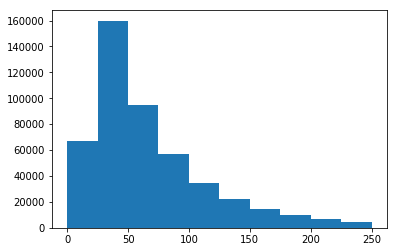

In [14]:
plt.hist(ltexts,range=[0,250])

In [15]:
def pad_texts(texts,W):
    fragments=[]
    fragment_labels=[]
    for idx,text in enumerate(texts):
            fragment=text[0:W]
            fragment=np.pad(fragment,(W-len(fragment),0),mode="constant",constant_values=-2)
            fragments.append(fragment)
    return np.array(fragments)

In [16]:
W=125

In [17]:
X_train=pad_texts(texts_train,W)
Y_train=labels_train>3
print(X_train.shape,Y_train.shape)

(486027, 125) (486027,)


In [18]:
X_val=pad_texts(texts_val,W)
Y_val=labels_val>3
print(X_val.shape,Y_val.shape)

(25581, 125) (25581,)


In [19]:
X_test=pad_texts(texts_test,W)
Y_test=labels_test>3
print(X_test.shape,Y_test.shape)

(56846, 125) (56846,)


In [20]:
X_train[0]

array([-2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,  4.4839e+04,
        1.0765e+04,  4.8210e+04,  3.5747e+04,  2.3155e+04,  4.4669e+04,
        3.2617e+04,  6.2360e+03,  1.8644e+04,  2.9720e+04,  2.2655e+04,
        1.5654e+04,  4.5233e+04,  1.0317e+04,  6.5730e+03,  2.9720e+04,
        1.1753e+04,  3.0350e+04,  2.6865e+04,  3.0000e+04,  2.4270e+04,
        2.0997e+04,  8.7540e+03,  2.7641e+04,  4.3350e+03,  4.0171e+04,
        2.3155e+04,  4.4669e+04,  3.2617e+04,  2.2284e+04,  4.4656e+04,
        4.9292e+04,  6.0480e+03,  1.8440e+03,  4.5233e+04,  4.2263e+04,
        4.4695e+04,  4.7108e+04,  2.5500e+03,  2.3155e+04,  4.4669e+04,
        1.9348e+04,  8.3380e+03,  4.6697e+04,  4.4656e+04,  4.8229e+04,
        4.4669e+04,  9.1410e+03,  1.6973e+04,  8.7540e+03,  4.46

In [21]:
X_train.max(),X_train.min()

(49999.0, -2.0)

## Text Embedding Model

In [22]:
num_classes = 2
V=len(countVectorizer.vocabulary_)+2 # one for unknown words, one for padding
print(num_classes,V)
E=128
F=128
hidden1=128

2 50002


## Convolutional Neural Network

### Build Dense Neural Network

In [23]:
# here we have to use the funtional interface rather than the sequential model
def text_conv_net(W,V,E,F,hidden1):
    input1 = keras.layers.Input(shape=(W,))
    adjust=keras.layers.Lambda(lambda x: x+2,input_shape=(W,))(input1) # add two to handle padding and unknown words
    embedding= keras.layers.Embedding(V,E,input_length=W)(adjust)
    conv1 = keras.layers.Convolution1D(F,2, padding="same")(embedding)
    features1=keras.layers.MaxPooling1D(pool_size=W)(conv1)
    conv2 = keras.layers.Convolution1D(F,3, padding="same")(embedding)
    features2=keras.layers.MaxPooling1D(pool_size=W)(conv2)
    conv3 = keras.layers.Convolution1D(F,4, padding="same")(embedding)
    features3=keras.layers.MaxPooling1D(pool_size=W)(conv3)
    concat= keras.layers.concatenate([features1,features2,features3])
    flat=keras.layers.Flatten()(concat)
    drop1=keras.layers.Dropout(0.5)(flat)
    dense1=keras.layers.Dense(hidden1, activation=keras.activations.relu)(drop1)
    drop2=keras.layers.Dropout(0.5)(dense1)
    out = keras.layers.Dense(1,activation="sigmoid")(drop2)
    model = keras.models.Model(inputs=[input1], outputs=out)
    return model

In [24]:
model0=text_conv_net(W,V,E,F,hidden1)

Instructions for updating:
Colocations handled automatically by placer.
2019-04-11 14:05:56,028|From /usr/local/share/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-04-11 14:05:56,123|From /usr/local/share/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
model0.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
model0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 125)          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 125)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 125, 128)     6400256     lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 125, 128)     32896       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (

In [27]:
X_train.shape

(486027, 125)

In [28]:
nepochs=5

In [29]:
model0.fit(X_train,Y_train,epochs=nepochs,validation_data=(X_val,Y_val),
          callbacks=[LoggingCallback(1,logger)],
                     batch_size=128)

Train on 486027 samples, validate on 25581 samples
Instructions for updating:
Use tf.cast instead.
2019-04-11 14:05:56,518|From /usr/local/share/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
486027/486027 [==============================] - 192s 395us/sample - loss: 0.2378 - acc: 0.9035 - val_loss: 0.1768 - val_acc: 0.9302
Epoch 2/5
486027/486027 [==============================] - 189s 389us/sample - loss: 0.1570 - acc: 0.9403 - val_loss: 0.1620 - val_acc: 0.9365
Epoch 3/5
269952/486027 [===============>..............] - ETA: 1:23 - loss: 0.1162 - acc: 0.9565

In [30]:
Y_pred=(model0.predict(X_val)>0.5).ravel()
np.mean(Y_pred==Y_val)

0.9380399515265236

In [31]:
classes=np.unique(Y_test)

Confusion matrix, without normalization
[[ 4779   923]
 [  662 19217]]


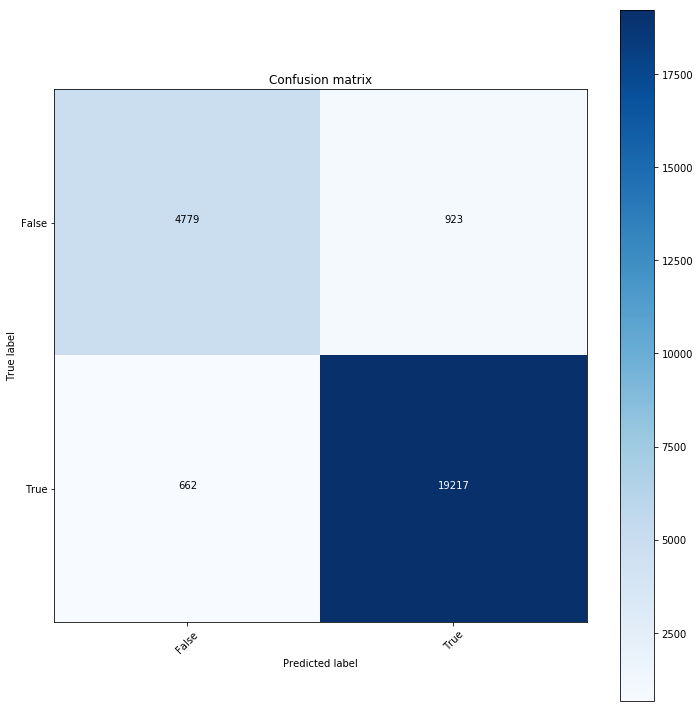

In [32]:
plt.figure(figsize=(10,10))
cnf_matrix = metrics.confusion_matrix(Y_val, Y_pred)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

### layer size optimization

In [33]:
F=256
hidden1=512
results=[]


for E in [100,200,300]:
        # Build the Estimator
        model=text_conv_net(W,V,E,F,hidden1)
        model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
        model.fit(X_train,Y_train,epochs=nepochs,validation_data=(X_val,Y_val),
          callbacks=[LoggingCallback(1,logger)],verbose=0,
                     batch_size=128)
        Y_pred=(model.predict(X_train)>0.5).ravel()
        acc_train=np.mean(Y_pred==Y_train)
        Y_pred=(model.predict(X_val)>0.5).ravel()
        acc_val=np.mean(Y_pred==Y_val)
        logger.info(f"{E},{F},{hidden1},{acc_train},{acc_val}")
        results.append((E,F,hidden1,acc_train,acc_val))

        

2019-04-11 14:27:09,199|	0: TRAIN loss 0.2309,  acc 0.9061  ||  VAL loss 0.1729, acc 0.9321
2019-04-11 14:32:17,768|	1: TRAIN loss 0.1494,  acc 0.9429  ||  VAL loss 0.1615, acc 0.9377
2019-04-11 14:37:26,532|	2: TRAIN loss 0.1108,  acc 0.9584  ||  VAL loss 0.1694, acc 0.9394
2019-04-11 14:42:35,390|	3: TRAIN loss 0.0835,  acc 0.9688  ||  VAL loss 0.1835, acc 0.9387
2019-04-11 14:47:44,303|	4: TRAIN loss 0.0652,  acc 0.9758  ||  VAL loss 0.2094, acc 0.9372
2019-04-11 14:48:52,349|100,256,512,0.9902824328689558,0.9372190297486416
2019-04-11 14:55:11,515|	0: TRAIN loss 0.2279,  acc 0.9073  ||  VAL loss 0.1721, acc 0.9320
2019-04-11 15:01:27,977|	1: TRAIN loss 0.1476,  acc 0.9440  ||  VAL loss 0.1618, acc 0.9386
2019-04-11 15:07:44,443|	2: TRAIN loss 0.1059,  acc 0.9602  ||  VAL loss 0.1662, acc 0.9400
2019-04-11 15:14:01,260|	3: TRAIN loss 0.0784,  acc 0.9711  ||  VAL loss 0.1829, acc 0.9388
2019-04-11 15:20:17,599|	4: TRAIN loss 0.0611,  acc 0.9777  ||  VAL loss 0.2025, acc 0.9405
2019-0

In [34]:
data=pd.DataFrame(results,columns=["E","F","layer1","train","valuation"])
data.head()

,E,F,layer1,train,valuation
0,100,256,512,0.990282,0.937219
1,200,256,512,0.991402,0.940503
2,300,256,512,0.992048,0.940503


The best model achieves 94% accuracy using a 300 dimensional embedding, 256 (3,4,5) n-grams and and a 512 hidden layer.

We could probably do better by increasing model size, but we need to stop somewhere.

### Test of best model

In [35]:
X=np.concatenate([X_train,X_val])
Y=np.concatenate([Y_train,Y_val])
print(X.shape,Y.shape)

(511608, 125) (511608,)


In [36]:
best=data.iloc[data["valuation"].idxmax()]
best_E=int(best["E"])
best

E            200.000000
F            256.000000
layer1       512.000000
train          0.991402
valuation      0.940503
Name: 1, dtype: float64

In [37]:
# Build the Estimator
model=text_conv_net(W,V,best_E,F,hidden1)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 125)          0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 125)          0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 125, 200)     10000400    lambda_4[0][0]                   
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 125, 256)     102656      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 

This model is a **very large** so fitting takes a while

In [39]:
model.fit(X,Y,epochs=nepochs,validation_data=(X_test,Y_test),
          callbacks=[LoggingCallback(1,logger)],verbose=0,
                     batch_size=128)

2019-04-11 16:07:21,060|	0: TRAIN loss 0.2248,  acc 0.9090  ||  VAL loss 0.1765, acc 0.9326
2019-04-11 16:14:02,586|	1: TRAIN loss 0.1452,  acc 0.9447  ||  VAL loss 0.1583, acc 0.9393
2019-04-11 16:20:44,229|	2: TRAIN loss 0.1052,  acc 0.9609  ||  VAL loss 0.1672, acc 0.9371
2019-04-11 16:27:25,928|	3: TRAIN loss 0.0785,  acc 0.9710  ||  VAL loss 0.1791, acc 0.9390
2019-04-11 16:34:06,686|	4: TRAIN loss 0.0608,  acc 0.9776  ||  VAL loss 0.2003, acc 0.9392


In [40]:
Y_pred=(model.predict(X_test)>0.5).ravel()
np.mean(Y_pred==Y_test)

0.9392217570277592

So we achieve 93.9% accuracy on the test set